# CNN pour l'extraction de relations




## Préparer les données

Les données sont initialement sous format txt.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import spacy
import numpy as np
import pandas as pd

import time
import random
import string
from itertools import chain

In [2]:
my_path = "./data_RE/"

Les données sous sous la forme suivante où les deux entitiés sont encadrées par `<e1>`, `</e1>` et  `<e2>`, `</e2>` et la relation est séparée du texte par une tabulation : 

`1. A hydrodesulfurization catalyst comprising alumina composited with silica in a weight ratio of from about 1.5 :l to about 9:1 and having composited therewith a metal of Group VI - B and a metal of Group VIII, said catalyst being characterized by an average pore volume of from a <e1>pore volume</e1> ut 0.5 cubic centimeter per  <e2>0.5</e2> m, an average pore diameter of from about 70 to about angstroms, a surface area of from about 150 to about 250 square meters per gram and an apparent bulk density of from about 0.625 to about 0.875 gram per cubic centimeter.	Is_defined`
    
    

In [3]:
import re
import os

pattern_repl = re.compile('(<e1>)|(</e1>)|(<e2>)|(</e2>)|(\'s)')
pattern_e1 = re.compile('<e1>(.*)</e1>')
pattern_e2 = re.compile('<e2>(.*)</e2>')
pattern_symbol = re.compile('^[!"#$%&\\\'()*+,-./:;<=>?@[\\]^_`{|}~]|[!"#$%&\\\'()*+,-./:;<=>?@[\\]^_`{|}~]$')

def delete_symbol(text):
    if pattern_symbol.search(text):
        return pattern_symbol.sub('', text)
    return text

def load_dataset(path_dataset):
    """Load dataset into memory from text file"""
    dataset = []
    with open(path_dataset) as f:
        piece = list()  # a piece of data
        for line in f:
            line = line.strip()
            if line:
                piece.append(line)
            elif piece:
                sentence = piece[0].split('\t')[1].strip('"')
                e1 = delete_symbol(pattern_e1.findall(sentence)[0])
                e2 = delete_symbol(pattern_e2.findall(sentence)[0])
                new_sentence = list()
                for word in pattern_repl.sub('', sentence).split(' '):
                    new_word = delete_symbol(word)
                    if new_word:
                        new_sentence.append(new_word)

                relation = piece[1]
                dataset.append(((e1, e2, ' '.join(new_sentence)), relation))
                piece = list()
    return dataset

def sdataset(dataset):
    sentences = []
    flabels = []

    for words, labels in dataset:
        sentences.append('{}'.format('  '.join(words)))
        flabels.append('{}'.format(labels))
    return  sentences, flabels

def save_dataset(dataset, save_dir, labels = True):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Export the dataset
    if labels == True : 
        with open(os.path.join(save_dir, 'sentences.txt'), 'w') as file_sentences, \
            open(os.path.join(save_dir, 'labels.txt'), 'w') as file_labels:
            for words, labels in dataset:
                file_sentences.write('{}\n'.format('\t'.join(words)))
                file_labels.write('{}\n'.format(labels))
    else:
        with open(os.path.join(save_dir, 'sentences.txt'), 'w') as file_sentences:
            for words in dataset:
                file_sentences.write('{}\n'.format('\t'.join(words)))


path_train = my_path + 'TRAIN_FILE.TXT'
path_test = my_path + 'TEST_FILE_FULL.TXT'
path_valid = my_path + 'TEST_FILE_FULL.TXT'

# charger le dataset
train_dataset = load_dataset(path_train)
test_dataset = load_dataset(path_test)
valid_dataset = load_dataset(path_valid)

# sauvegarder le dataset pré-traité
sent_train, label_train = sdataset(train_dataset)
sent_test, label_test = sdataset(test_dataset)
sent_valid, label_valid = sdataset(valid_dataset)

# sauvegarder le dataset pré-traité
save_dataset(train_dataset, my_path + '/corpus/train')
save_dataset(test_dataset, my_path + '/corpus/test')
save_dataset(valid_dataset, my_path + '/corpus/valid')

On a alors des données sous la forme suivante où les deux entitées sont au début de la phrase et sont séparées par une tabulation : 

In [4]:
import pandas as pd

train = pd.DataFrame({'text': sent_train, 'label': label_train})
test = pd.DataFrame({'text':sent_test, 'label': label_test})
valid = pd.DataFrame({'text':sent_valid, 'label': label_valid})
train.head(6)

,text,label
0,configuration elements The system as describ...,"Component-Whole(e2,e1)"
1,child cradle The child was carefully wrapped...,Other
2,author disassembler The author of a keygen u...,"Instrument-Agency(e2,e1)"
3,ridge surge A misty ridge uprises from the s...,Other
4,student association The student association ...,"Member-Collection(e1,e2)"
5,complex producer This is the sprawling compl...,Other


In [5]:
print(f"Number of training examples: {len(train)}")
print(f"Number of validation examples: {len(valid)}")
print(f"Number of testing examples: {len(test)}")

Number of training examples: 8000
Number of validation examples: 2717
Number of testing examples: 2717


Affichage de la distribution des labels dans les données train.

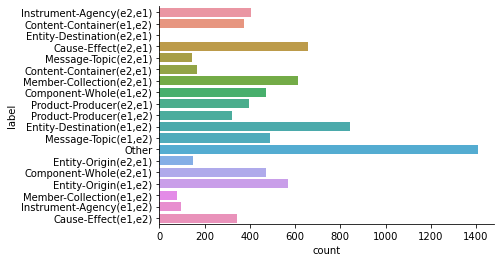

In [6]:
count = []
for i in set(train['label']):
    count.append(train['label'].value_counts()[i])
    
labels = set(train['label'])
tag_counts_percentages = pd.DataFrame({'label':list(labels), 'count': count})
import seaborn as sns
sns.barplot(data=tag_counts_percentages,y='label',x='count')
sns.despine()

Dans l'échantillon de validation : 

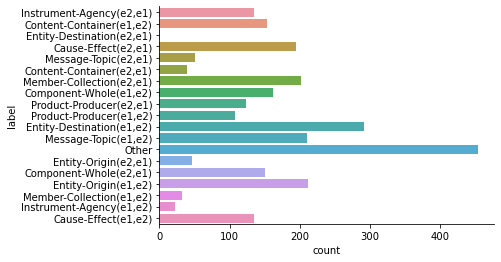

In [7]:
count = []
for i in set(valid['label']):
    count.append(valid['label'].value_counts()[i])
    
labels = set(valid['label'])
tag_counts_percentages = pd.DataFrame({'label':list(labels), 'count': count})
import seaborn as sns
sns.barplot(data=tag_counts_percentages,y='label',x='count')
sns.despine()

On crée le vocabulaire en utilisant les fonctions suivantes.

In [8]:
def save_to_txt(vocab, txt_path):
    with open(txt_path, 'w') as f:
        for token in vocab:
            f.write(token + '\n')
            
def update_vocab(txt_path, vocab):
    """Update word and label vocabulary from dataset"""
    vocab.update(["<pad>"])
    vocab.update(["<unk>"])
    with open(txt_path) as f:
        for i, line in enumerate(f):
            line = line.strip()
            if line.endswith('...'):
                line = line.rstrip('...')
            word_seq = line.split('\t')[-1].split(' ')
            vocab.update(word_seq)
    return i + 1

def update_labels(txt_path, labels):
    """Update label vocabulary from dataset"""
    labels.update(["<pad>"])
    with open(txt_path) as f:
        for i, line in enumerate(f):
            line = line.strip()  # one label per line
            labels.update([line])      
    return i + 1

Création de fichiers `sentences.txt` et `labels.txt`.

In [9]:
from collections import Counter

words = Counter()
size_train_sentences = update_vocab(os.path.join(my_path + '/corpus/train/sentences.txt'), words)
size_test_sentences = update_vocab(os.path.join(my_path +'/corpus/test/sentences.txt'), words)
size_valid_sentences = update_vocab(os.path.join(my_path +'/corpus/valid/sentences.txt'), words)

labels = Counter()
size_train_tags = update_labels(os.path.join(my_path +'/corpus/train/labels.txt'), labels)
size_test_tags = update_labels(os.path.join(my_path +'/corpus/test/labels.txt'), labels)
size_valid_tags = update_labels(os.path.join(my_path +'/corpus/valid/labels.txt'), labels)

min_count_word = 0
min_count_tag = 0 

# Vocabulaire
words = ([tok for tok, count in words.items() if count >= min_count_word])
labels = sorted([tok for tok, count in labels.items() if count >= min_count_tag])

Les fonctions suivantes sont utilisées pour initialisé l'embedding à zéro pour le token `<pad>` et aléatoirement en utilisant une distribution normale pour le token `<unk>`.

In [10]:
def generate_zero_vector(embedding_dim):
    return [0] * embedding_dim

def generate_random_vector(embedding_dim):
    return np.random.uniform(-np.sqrt(3.0 / embedding_dim), np.sqrt(3.0 / embedding_dim),
                             embedding_dim).tolist()

On charge les embeddings.

In [11]:
embedding_vectors = list()
word2idx = dict()
label2idx = dict()

word_emb_dim = 50

word2idx["<pad>"] = 0
embedding_vectors.append(generate_zero_vector(word_emb_dim))

word2idx["<unk>"] = 1
embedding_vectors.append(generate_random_vector(word_emb_dim))


for i, line in enumerate(labels):
    label2idx[line.strip()] = i

def load_embeddings_from_file(emb_path, emb_delimiter):
    with open(emb_path, 'r') as f:
        for line in f:
            values = line.strip().split(emb_delimiter)
            word = values[0]
            emb_vector = list(map(float, filter(str.strip, values[1:])))
            yield word, emb_vector
            
def get_loaded_embedding_vectors():
    return torch.FloatTensor((embedding_vectors))

def get_embedding_word(word, embedding_words):
    original_words_num = 0
    lowercase_words_num = 0
    zero_digits_replaced_num = 0
    zero_digits_replaced_lowercase_num = 0
    
    if word in embedding_words:
        original_words_num += 1
        return word
    elif word.lower() in embedding_words:
        lowercase_words_num += 1
        return word.lower()
    elif re.sub(r'\d', '0', word) in embedding_words:
        zero_digits_replaced_num += 1
        return re.sub(r'\d', '0', word)
    elif re.sub(r'\d', '0', word.lower()) in embedding_words:
        zero_digits_replaced_lowercase_num += 1
        return re.sub(r'\d', '0', word.lower())
    return None

On crée le vecteur d'embedding `embedding_vectors`.

In [12]:
glove_6B_300d = list(load_embeddings_from_file(emb_path=my_path + 'embeddings/vector_50d.txt', emb_delimiter=' '))
embedding_words = [emb_word for emb_word, _ in glove_6B_300d]
        
emb_word2unique_word = dict()  # emb_word <-> [unique_word_1, unique_word_2, ...]
out_of_vocab_words = list()
for unique_word in map(str.strip, words):
    emb_word = get_embedding_word(unique_word, embedding_words)
    if emb_word is None:
        out_of_vocab_words.append(unique_word)
    else:
        emb_word2unique_word.setdefault(emb_word, []).append(unique_word)

for emb_word, emb_vector in glove_6B_300d:                                                                
    if emb_word in emb_word2unique_word:
        for unique_word in emb_word2unique_word[emb_word]:
            word2idx[unique_word] = len(word2idx)
            embedding_vectors.append(emb_vector)

Les fonctions ci-dessous permettent de mapper les tokens et les labels avec leurs indices et de retourner les positions des entités pour chaque phrase. 

In [37]:
def get_pos_feature(x, pos_dis_limit = 50):
    """Position relative"""
    if x < -pos_dis_limit:
        return 0
    if x <= pos_dis_limit:
        return x + pos_dis_limit + 1
    return pos_dis_limit * 2 + 2       

def index(liste, elements):
    assert elements, elements
    if len(elements) == 1:
        return liste.index(elements[0])
    for index, item in enumerate(liste):
        if elements[0] == item:
            return all(a == b for a, b in zip(liste[index+1:], elements[1:]))
    raise ValueError()

def load_sentences_labels(sentences_file=None, labels_file=None, sentence = None):
        """Charge les phrases et les labels à partir de leurs fichiers correspondants. 
           Mappe les tokens et les balises à leurs index et les stocke dans le dict d.
        """
        sents, pos1s, pos2s = list(), list(), list()
        labels = list()
        d = dict()
        # Remplacez chaque token par son index s'il est dans le vocabulaire, sinon utilisez l'index de unk_word
        if sentences_file is not None: 
            with open(sentences_file, 'r') as f:
                sentence = list(map(str.strip, f))

        for i, line in enumerate(sentence):
            while "  " in line:
                line = line.replace("  ", " ")
            e1, e2, sent = line.strip().split('\t')
            words = sent.split()
            if e1 in words:
                e1_idx = index(words, e1.split())  
            if e2 in words:
                e2_idx = index(words, e2.split())  

            sent, pos1, pos2 = list(), list(), list()
            for idx, word in enumerate(words):
                emb_word = get_embedding_word(word, word2idx)
                sent.append(word2idx[word] if emb_word else 1)
                pos1.append(get_pos_feature(idx - e1_idx))
                pos2.append(get_pos_feature(idx - e2_idx))
                        
            sents.append(sent)
            pos1s.append(pos1)
            pos2s.append(pos2)

        if labels_file is not None: 
            # Remplacez chaque label par son index
            with open(labels_file, 'r') as f:
                for line in f:
                    idx = label2idx[line.strip()]
                    labels.append(idx)

            # Vérifiez qu'il y a un tag pour chaque phrase
            assert len(labels) == len(sents)
            d['labels'] = labels

        # Stockage des données et des labels dans dict d
        d['data'] = {'sents': sents, 'pos1s': pos1s, 'pos2s': pos2s}
        
        d['size'] = len(sents)
        
        return d

In [14]:
d_test = load_sentences_labels(sentences_file = my_path + '/corpus/test/sentences.txt', labels_file = my_path +'/corpus/test/labels.txt')

In [15]:
d_train = load_sentences_labels(sentences_file = my_path +'/corpus/train/sentences.txt', labels_file = my_path +'/corpus/train/labels.txt')

In [16]:
d_valid = load_sentences_labels(sentences_file = my_path +'/corpus/valid/sentences.txt', labels_file = my_path +'/corpus/valid/labels.txt')

 - Création d'un itérateur :

In [17]:
    def data_iterator(data, batch_size, shuffle='False', max_len = 100, pos_dis_limit = 50):
      
        order = list(range(data['size']))
        if shuffle:
            random.seed(230)
            random.shuffle(order)
        # one pass over data
        for i in range((data['size'])//batch_size):
            # fetch data and labels
            batch_sents = [data['data']['sents'][idx] for idx in order[i*batch_size:(i+1)*batch_size]]
            batch_pos1s = [data['data']['pos1s'][idx] for idx in order[i*batch_size:(i+1)*batch_size]]
            batch_pos2s = [data['data']['pos2s'][idx] for idx in order[i*batch_size:(i+1)*batch_size]]
            batch_labels = [data['labels'][idx] for idx in order[i*batch_size:(i+1)*batch_size]]

            # Compute length of longest sentence in batch, and given batch_max_len.
            temp_len = max([len(s) for s in batch_sents])
            batch_max_len = temp_len if temp_len < max_len else max_len

            batch_data_sents = 0 * np.ones((batch_size, batch_max_len))
            batch_data_pos1s = (pos_dis_limit * 2 + 2) * np.ones((batch_size, batch_max_len))
            batch_data_pos2s = (pos_dis_limit * 2 + 2) * np.ones((batch_size, batch_max_len))
            for j in range(batch_size):
                cur_len = len(batch_sents[j])
                min_len = min(cur_len, batch_max_len)
                batch_data_sents[j][:min_len] = batch_sents[j][:min_len]
                batch_data_pos1s[j][:min_len] = batch_pos1s[j][:min_len]
                batch_data_pos2s[j][:min_len] = batch_pos2s[j][:min_len]

            # Convert indices data to torch LongTensors, and shift tensors to GPU if available.
            batch_data_sents = (torch.LongTensor(batch_data_sents)).to(device)
            batch_data_pos1s = (torch.LongTensor(batch_data_pos1s)).to(device)
            batch_data_pos2s = (torch.LongTensor(batch_data_pos2s)).to(device)
            batch_labels = (torch.LongTensor(batch_labels)).to(device)

            batch_data = {'sents': batch_data_sents, 'pos1s': batch_data_pos1s, 'pos2s': batch_data_pos2s}
            yield batch_data, batch_labels

## Construire le modèle

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, pos_dis_limit, pos_emb_dim, dropout, word_emb_dim, filter_num, filters):
        super(Net, self).__init__()

        # chargement des vecteurs d'embeddings de l'ensemble de données
        embedding_vectors = get_loaded_embedding_vectors()
        
        # couche d'embeddings de mots et de positions
        self.word_embedding = nn.Embedding.from_pretrained(embeddings=embedding_vectors, freeze=False) 
        self.pos1_embedding = nn.Embedding(pos_dis_limit * 2 + 3, pos_emb_dim)
        self.pos2_embedding = nn.Embedding(pos_dis_limit * 2 + 3, pos_emb_dim)

        # couche dropout
        self.dropout = nn.Dropout(dropout)
        
        feature_dim = word_emb_dim + pos_emb_dim * 2
        
        # couche cnn
        self.covns = nn.ModuleList([nn.Conv2d(in_channels=1,
                                              out_channels=filter_num,
                                              kernel_size=(k, feature_dim),
                                              padding=0) for k in filters])

        filter_dim = filter_num * len(filters)
        labels_num =  len(label2idx)
        
        # couche de sortie
        self.linear = nn.Linear(filter_dim, labels_num)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        batch_sents = x['sents']
        batch_pos1s = x['pos1s']
        batch_pos2s = x['pos2s']

        word_embs = self.word_embedding(batch_sents)
        pos1_embs = self.pos1_embedding(batch_pos1s)
        pos2_embs = self.pos2_embedding(batch_pos2s)

        input_feature = torch.cat([word_embs, pos1_embs, pos2_embs], dim=2)  # batch_size x batch_max_len x feature_dim
        x = input_feature.unsqueeze(1)  # batch_size x 1 x batch_max_len x feature_dim
        
        x = self.dropout(x)
        
        x = [torch.tanh(conv(x)).squeeze(3) for conv in self.covns]  # x[idx]: batch_size x batch_max_len x (batch_max_len-knernel_size+1)
        
        x = [F.max_pool1d(i, kernel_size=i.size(2)).squeeze(2) for i in x]  # x[idx]: batch_size x filter_num
        sentence_features = torch.cat(x, dim=1)  # batch_size x (filter_num * len(filters))

        x = self.dropout(sentence_features)

        x = self.linear(x)

        return x

On définit `device` qui permet d'utiliser le GPU, s'il y en a un.

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [20]:
def count_parameters(model): 
    s = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Le modèle a {s:,} paramètres à entraîner')


def modele(dropout = 0.8, pos_dis_limit = 50, pos_emb_dim = 10, filter_num = 100, filters = (2,3,4,5)):
    word_emb_dim = 50 # doit être le même que la dimension du GloVe embeddings
    m = Net(pos_dis_limit, pos_emb_dim, dropout, word_emb_dim, filter_num, list(filters)).to(device)
    
    return m

In [21]:
TAG_PAD_IDX = 0
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX).to(device)

def optimiseur(model, lr=3e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

In [22]:
from sklearn.metrics import f1_score
import math


def f1_loss(predict_label, true_label, class_num=10):
    
    assert true_label.shape[0] == predict_label.shape[0]
    confusion_matrix = np.zeros(shape=[class_num, class_num], dtype=np.float32)
    xDIRx = np.zeros(shape=[class_num], dtype=np.float32)
    for i in range(true_label.shape[0]):
        true_idx = math.ceil(true_label[i]/2)
        predict_idx = math.ceil(predict_label[i]/2)
        if true_label[i] == predict_label[i]:
            confusion_matrix[predict_idx][true_idx] += 1
        else:
            if true_idx == predict_idx:
                xDIRx[predict_idx] += 1
            else:
                confusion_matrix[predict_idx][true_idx] += 1

    col_sum = np.sum(confusion_matrix, axis=0).reshape(-1)
    row_sum = np.sum(confusion_matrix, axis=1).reshape(-1)
    f1 = np.zeros(shape=[class_num], dtype=np.float32)

    for i in range(0, class_num): 
        try:
            p = float(confusion_matrix[i][i]) / float(col_sum[i] + xDIRx[i])
            r = float(confusion_matrix[i][i]) / float(row_sum[i] + xDIRx[i])
            f1[i] = (2 * p * r / (p + r))
        except:
            pass
    actual_class = 0
    total_f1 = 0.0
    for i in range(1, class_num):
        if f1[i] > 0.0: 
            actual_class += 1
            total_f1 += f1[i]
    try:
        macro_f1 = total_f1 / actual_class
    except:
        macro_f1 = 0.0
    return macro_f1
def f1_loss(preds, y, tag_pad_idx):
   
    positive_labels = [i for i in range(len(label2idx))
                           if i != tag_pad_idx]
    _, pred = torch.max(preds, 1)
    pred = pred.data.cpu().numpy() 
    tags = y.data.cpu().numpy()
    f1 = f1_score(
            y_true=tags,
            y_pred=pred,
            labels=positive_labels,
            average="micro"
        ) 
       
    return f1, pred, tags


In [23]:
def train_model(model, iterator, optimizer, criterion, tag_pad_idx):
    epoch_loss = 0
    epoch_f1 = 0
    model.train()
    c = 0
    for batch in iterator:
       
        text, tags = batch      
        optimizer.zero_grad() 
        #text = [sent len, batch size]    
        predictions = model(text)
     
        #predictions = [ batch size, output dim]
        #tags = [ batch size]   
        predictions = predictions.view(-1, predictions.shape[-1])

        tags= tags.view(-1)
       
        loss = criterion(predictions, tags)
        f1,_,_ = f1_loss(predictions, tags, tag_pad_idx)
        
        loss.backward()
        
        optimizer.step()

        c += 1 
        epoch_loss += loss.item()
        epoch_f1 += f1.item()
  
    return epoch_loss / c,  epoch_f1 / c

def evaluate(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_f1 = 0
    c = 0
    preds = []
    labels = []
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
  
            text, tags = batch
            predictions = model(text)
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            loss = criterion(predictions, tags)
            
            f1, pred, lab = f1_loss(predictions, tags, tag_pad_idx)
            preds.append(pred)
            labels.append(lab)
            epoch_loss += loss.item()
            epoch_f1 += f1.item()
            c +=1
            
    return epoch_loss / c, epoch_f1 / c, preds, labels

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def entrainement(model, optimizer, batch_size = 50, N_EPOCHS = 50):
    t_loss = []
    t_f1 = []
    v_loss = []
    v_f1 = []
    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):

        start_time = time.time()

        train_iterator = data_iterator(d_train, batch_size, shuffle='False')
        valid_iterator = data_iterator(d_valid, batch_size, shuffle='True')


        train_loss, train_f1 = train_model(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)
        t_loss.append(train_loss)
        t_f1.append(train_f1) 
        
        valid_loss, valid_f1,_,_ = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX)
        v_loss.append(valid_loss)
        v_f1.append(valid_f1)
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut1-model_re.pt')

        if epoch%10 == 0: 
            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train F1 score: {train_f1*100:.2f}%')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1 score: {valid_f1*100:.2f}%')
    return t_loss, v_loss, t_f1, v_f1

In [25]:
m = modele(dropout=0.8)
count_parameters(m)

Le modèle a 1,306,380 paramètres à entraîner


In [26]:
N_EPOCHS = 100

t_l, v_l, t_f1, v_f1 = entrainement(m, optimiseur(m, lr = 1e-3, weight_decay_rate = 0.01), N_EPOCHS = N_EPOCHS)

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 3.092 | Train F1 score: 11.23%
	 Val. Loss: 2.598 |  Val. F1 score: 18.93%
Epoch: 11 | Epoch Time: 0m 1s
	Train Loss: 2.360 | Train F1 score: 25.54%
	 Val. Loss: 2.143 |  Val. F1 score: 33.79%
Epoch: 21 | Epoch Time: 0m 1s
	Train Loss: 2.041 | Train F1 score: 35.45%
	 Val. Loss: 1.720 |  Val. F1 score: 51.21%
Epoch: 31 | Epoch Time: 0m 1s
	Train Loss: 1.855 | Train F1 score: 40.96%
	 Val. Loss: 1.552 |  Val. F1 score: 54.97%
Epoch: 41 | Epoch Time: 0m 1s
	Train Loss: 1.700 | Train F1 score: 45.35%
	 Val. Loss: 1.427 |  Val. F1 score: 57.59%
Epoch: 51 | Epoch Time: 0m 1s
	Train Loss: 1.617 | Train F1 score: 47.75%
	 Val. Loss: 1.326 |  Val. F1 score: 61.19%
Epoch: 61 | Epoch Time: 0m 1s
	Train Loss: 1.519 | Train F1 score: 51.11%
	 Val. Loss: 1.269 |  Val. F1 score: 62.05%
Epoch: 71 | Epoch Time: 0m 1s
	Train Loss: 1.431 | Train F1 score: 53.38%
	 Val. Loss: 1.209 |  Val. F1 score: 64.70%
Epoch: 81 | Epoch Time: 0m 1s
	Train Loss: 1.398 | Train

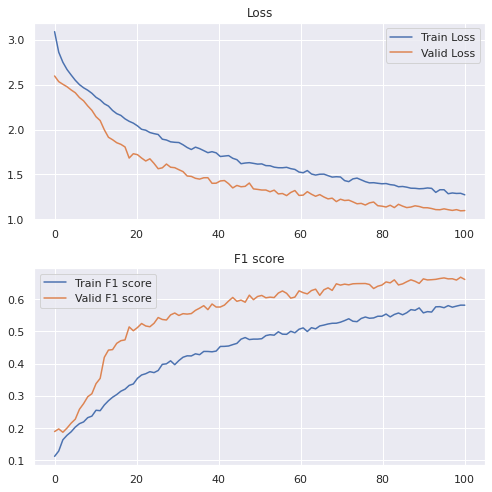

In [27]:
import matplotlib.pyplot as plt

sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

f = plt.figure(figsize=(7, 7))
gs = f.add_gridspec(2, 1)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0])
    plt.plot(x,t_l, label='Train Loss')
    plt.plot(x,v_l, label='Valid Loss')
    plt.title("Loss")
    plt.legend()
        
    ax = f.add_subplot(gs[1])
    plt.plot(x, t_f1, label='Train F1 score')
    plt.plot(x, v_f1, label='Valid F1 score')
    plt.title("F1 score")
    plt.legend()
      
f.tight_layout()

In [28]:
m.load_state_dict(torch.load('tut1-model_re.pt'))
test_iterator = data_iterator(d_test, batch_size = 10, shuffle='False')
test_loss, test_f1, preds, labels = evaluate(m, test_iterator, criterion, TAG_PAD_IDX)
print(f'Test Loss: {test_loss:.3f} |  Test F1 score: {test_f1*100:.2f}%')

Test Loss: 1.093 |  Test F1 score: 66.83%


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
predict =  [item for sublist in preds for item in sublist]
true =  [item for sublist in labels for item in sublist]

positive_labels = [i for i in range(len(label2idx)) if i != 0]
positive_names = [list(label2idx.keys())[list(label2idx.values()).index(i)] for i in range(len(label2idx)) if i != 0]
print(classification_report(
                y_true=true,
                y_pred=predict,
                labels=positive_labels,
                target_names=positive_names
            ))


                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.90      0.84      0.87       134
      Cause-Effect(e2,e1)       0.92      0.82      0.87       194
   Component-Whole(e1,e2)       0.62      0.74      0.67       161
   Component-Whole(e2,e1)       0.72      0.55      0.62       150
 Content-Container(e1,e2)       0.69      0.88      0.77       153
 Content-Container(e2,e1)       0.77      0.62      0.69        39
Entity-Destination(e1,e2)       0.73      0.92      0.81       290
Entity-Destination(e2,e1)       0.00      0.00      0.00         1
     Entity-Origin(e1,e2)       0.75      0.86      0.80       210
     Entity-Origin(e2,e1)       0.82      0.77      0.79        47
 Instrument-Agency(e1,e2)       0.50      0.41      0.45        22
 Instrument-Agency(e2,e1)       0.49      0.70      0.58       133
 Member-Collection(e1,e2)       0.55      0.38      0.44        32
 Member-Collection(e2,e1)       0.83      0.81      0.82     

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
confusion = confusion_matrix(true, predict)
l = positive_names

In [32]:
confusion_df =pd.DataFrame(confusion)

confusion_df.columns=l
s = pd.Series(l)
confusion_df = confusion_df.set_index([s])


confusion_df

,"Cause-Effect(e1,e2)","Cause-Effect(e2,e1)","Component-Whole(e1,e2)","Component-Whole(e2,e1)","Content-Container(e1,e2)","Content-Container(e2,e1)","Entity-Destination(e1,e2)","Entity-Destination(e2,e1)","Entity-Origin(e1,e2)","Entity-Origin(e2,e1)","Instrument-Agency(e1,e2)","Instrument-Agency(e2,e1)","Member-Collection(e1,e2)","Member-Collection(e2,e1)","Message-Topic(e1,e2)","Message-Topic(e2,e1)",Other,"Product-Producer(e1,e2)","Product-Producer(e2,e1)"
"Cause-Effect(e1,e2)",113,0,2,1,0,0,0,0,0,0,0,1,0,0,3,2,12,0,0
"Cause-Effect(e2,e1)",5,160,1,0,0,0,0,0,15,0,0,0,0,0,0,2,6,5,0
"Component-Whole(e1,e2)",0,0,119,2,6,1,1,0,0,0,1,3,2,3,0,6,17,0,0
"Component-Whole(e2,e1)",0,0,7,82,2,1,5,0,0,2,0,12,0,3,4,7,25,0,0
"Content-Container(e1,e2)",0,0,4,1,135,2,5,0,1,1,0,0,0,0,0,1,3,0,0
"Content-Container(e2,e1)",0,0,0,2,7,24,0,0,0,2,0,0,0,0,1,1,2,0,0
"Entity-Destination(e1,e2)",0,0,2,0,17,0,266,0,0,0,0,0,0,0,1,1,3,0,0
"Entity-Destination(e2,e1)",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
"Entity-Origin(e1,e2)",0,1,1,0,2,0,5,0,181,2,0,0,0,0,0,5,13,0,0
"Entity-Origin(e2,e1)",0,0,1,0,0,0,0,0,0,36,0,1,0,0,0,0,9,0,0


In [34]:
def sentence_process(line):
    dataset = []
    piece = list()  # a piece of data
    line = line.strip()
    if line:
        piece.append(line)         
        sentence = line.split('\t')[0].strip('"').lower()

            
        e1 = delete_symbol(pattern_e1.findall(sentence)[0])
        e2 = delete_symbol(pattern_e2.findall(sentence)[0])
        new_sentence = list()
        for word in pattern_repl.sub('', sentence).split(' '):
            new_word = delete_symbol(word)
            if new_word:
                new_sentence.append(new_word)
        if e1 != '' and e2 != '':
            dataset.append((e1+'\t'+ e2+ '\t'+ ' '.join(new_sentence)))
            piece = list() 
    sentences = []

    for words in dataset:
        sentences.append('{}'.format('  '.join(words)))
        
    return  dataset


In [38]:
import re
def tag_sentence(model, device, sentence):
    
    t = sentence_process(sentence)
    vocab = Counter()
    for i in t:
    
        save_dataset(i, 'data/corpus/inf', labels = False)
    
    line  = t
    vocab.update(["<pad>"])
    vocab.update(["<unk>"])
    for line in t :
       
        line = line.strip()
        word_seq = line.split('\t')[-1].split(' ')
        vocab.update(word_seq)
    
    
    data = load_sentences_labels(sentence = t)
    model.eval()
    batch_size = 1
    order = list(range(data['size']))
    for i in range((data['size'])//batch_size):
        # fetch data and labels
        batch_sents = [data['data']['sents'][idx] for idx in order[i*batch_size:(i+1)*batch_size]]
        batch_pos1s = [data['data']['pos1s'][idx] for idx in order[i*batch_size:(i+1)*batch_size]]
        batch_pos2s = [data['data']['pos2s'][idx] for idx in order[i*batch_size:(i+1)*batch_size]]
    
    batch_data_sents = (torch.LongTensor(batch_sents)).to(device)
    batch_data_pos1s = (torch.LongTensor(batch_pos1s)).to(device)
    batch_data_pos2s = (torch.LongTensor(batch_pos2s)).to(device)

    batch_data = {'sents': batch_data_sents, 'pos1s': batch_data_pos1s, 'pos2s': batch_data_pos2s}
    
    predictions = model(batch_data)
    
    top_predictions = predictions.argmax(-1)
    predicted_tags = [list(label2idx.keys())[list(label2idx.values()).index(t)] for t in top_predictions]
    
    return predicted_tags

On teste l'algorithme en utilisant la fonction précédente et la phrase suivante :


"The `<e1>ear</e1>` of the African `<e2>elephant</e2>` is significantly larger--measuring 183 cm by 114 cm in the bush elephant."

La relation retournée doit être `Component-Whole(e1,e2)`.

In [41]:
sentence = "The <e1>ear</e1> of the African <e2>elephant</e2> is significantly larger--measuring 183 cm by 114 cm in the bush elephant."
pred_tags = tag_sentence(m, device, sentence)
print(pred_tags)

['Component-Whole(e1,e2)']
